In [1]:
import graspy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from graspy.embed import select_dimension, AdjacencySpectralEmbed
from graspy.utils import remove_loops, symmetrize, binarize
from graspy.inference.latent_distribution_test import _median_sign_flips
from graspy.inference import LatentDistributionTest

from hyppo.ksample import KSample
from hyppo._utils import gaussian

import sys
sys.path.append("../")
from seedless_procrustes import *

%matplotlib inline

print(graspy.__version__)

0.3.0


In [2]:
with open('./data/left_adjacency.csv') as csv_file:
    A_l = np.loadtxt(csv_file, dtype=int)
with open('./data/right_adjacency.csv') as csv_file:
    A_r = np.loadtxt(csv_file, dtype=int)
    
print(A_l.shape, A_r.shape)

hemispheres = ['Left'] * 209 + ['Right'] * 213


(209, 209) (213, 213)


<AxesSubplot:title={'center':'Right'}>

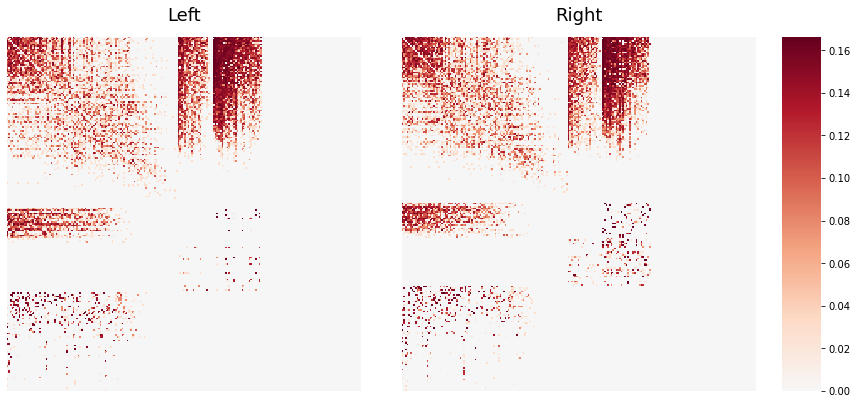

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5.5), gridspec_kw=dict(width_ratios=(1, 1, 0.1)), constrained_layout=True)
graspy.plot.heatmap(A_l, transform='simple-all', ax = ax[0], title="Left", cbar_ax=ax[-1])
graspy.plot.heatmap(A_r, transform='simple-all', ax = ax[1], title="Right",  cbar_ax=ax[-1])

In [5]:
A_l_processed = binarize(A_l)
A_r_processed = binarize(A_r)

<AxesSubplot:title={'center':'Right'}>

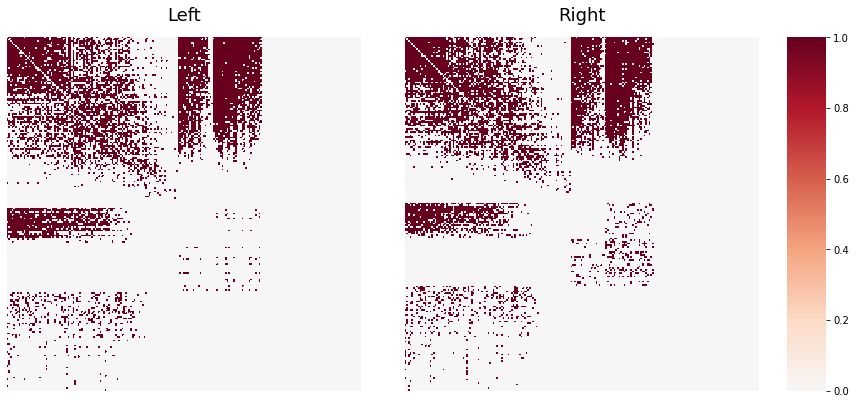

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5.5), gridspec_kw=dict(width_ratios=(1, 1, 0.1)), constrained_layout=True)
graspy.plot.heatmap(A_l_processed, transform='simple-all', ax = ax[0], title="Left", cbar_ax=ax[-1])
graspy.plot.heatmap(A_r_processed, transform='simple-all', ax = ax[1], title="Right",  cbar_ax=ax[-1])

In [9]:
num_dims1 = select_dimension(A_l_processed)[0][-1]
num_dims2 = select_dimension(A_r_processed)[0][-1]
n_components = max(num_dims1, num_dims2)

print(n_components)

3


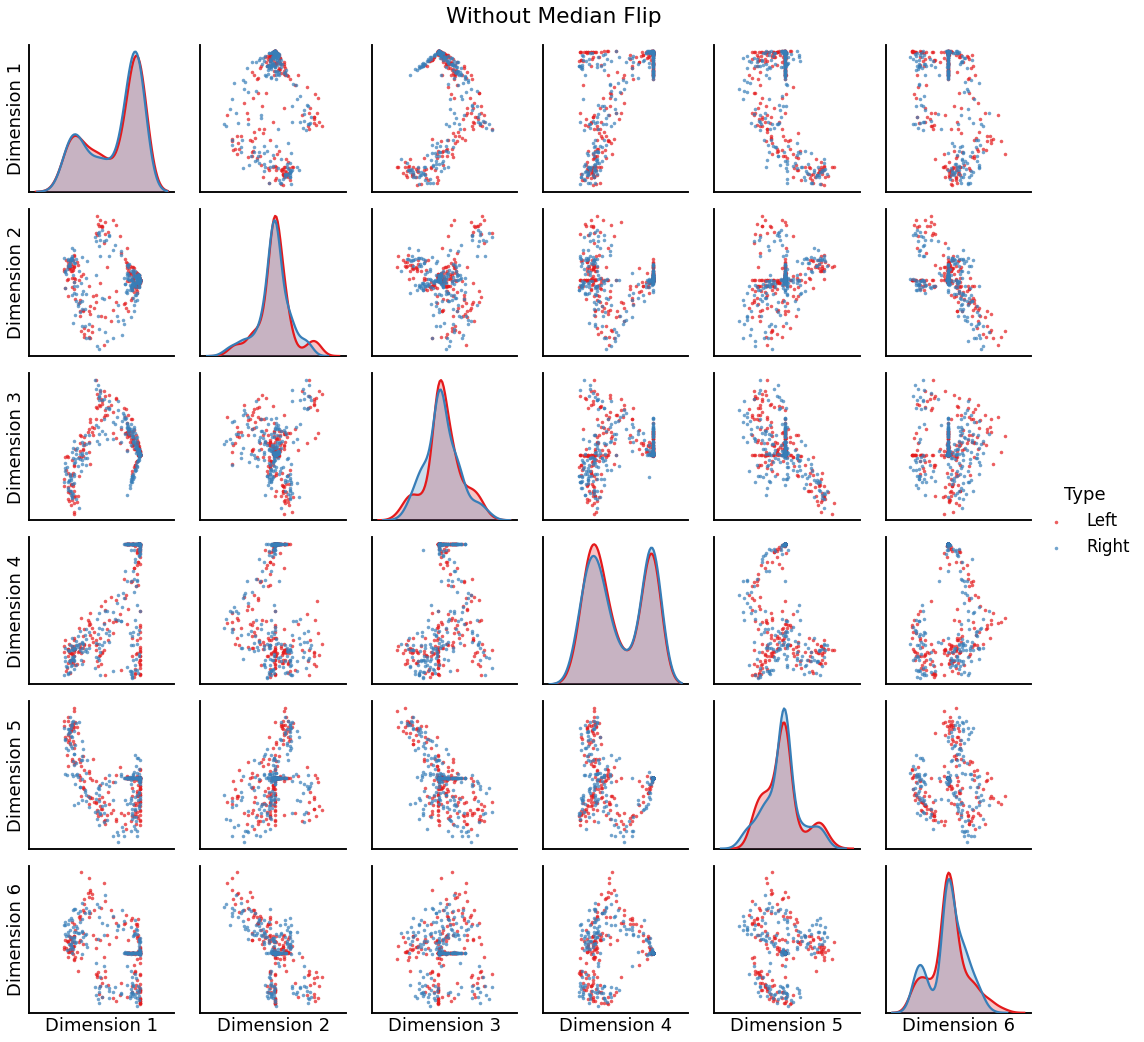

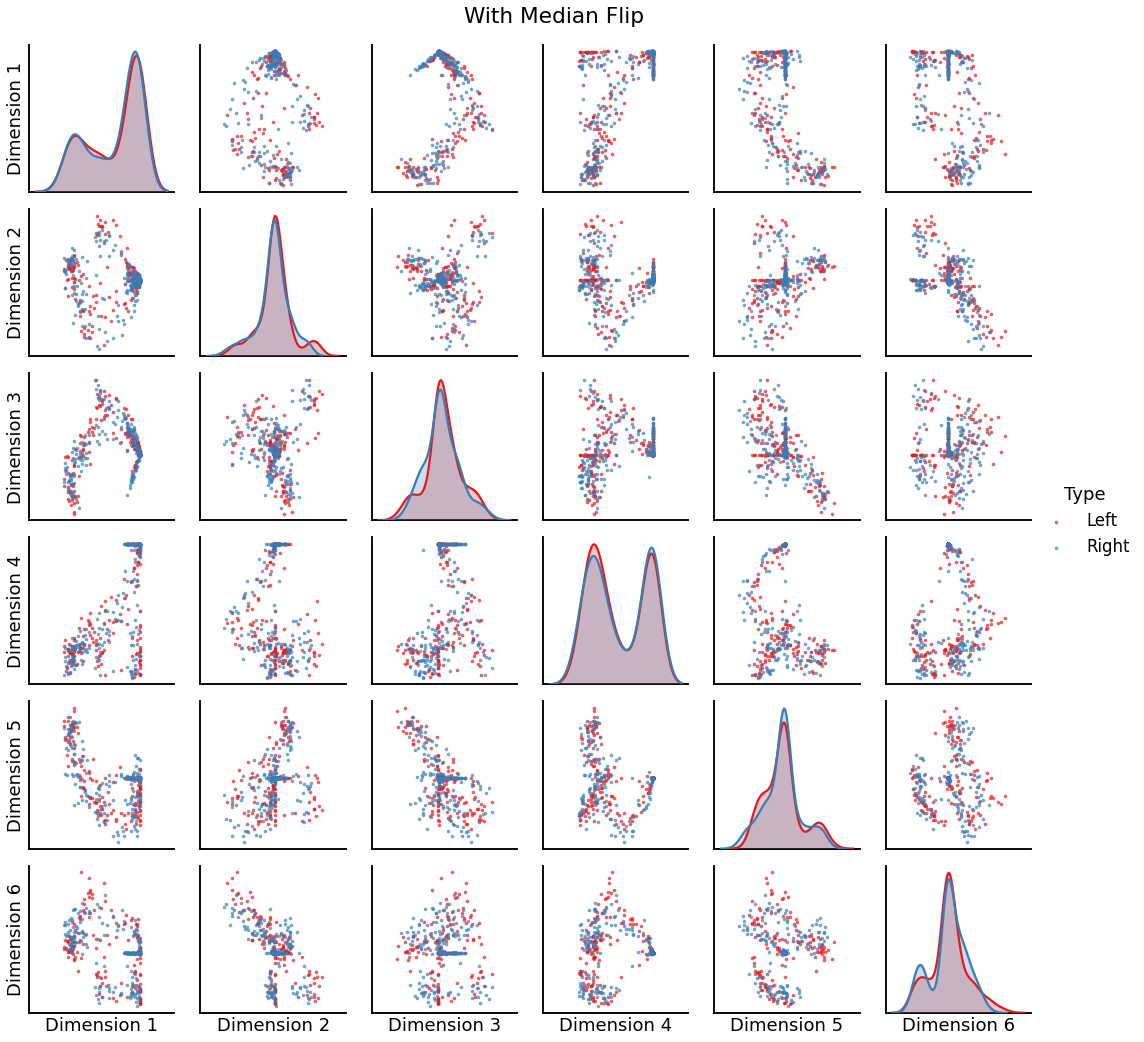

In [11]:
ase = AdjacencySpectralEmbed(n_components=n_components, algorithm='full', diag_aug=True, check_lcc=False)
X1_hat = np.hstack(ase.fit_transform(A_l_processed))
X2_hat = np.hstack(ase.fit_transform(A_r_processed))

X1_hat_flipped, X2_hat_flipped = _median_sign_flips(X1_hat, X2_hat)

fig = graspy.plot.pairplot(np.vstack([X1_hat, X2_hat]), labels=hemispheres, title="Without Median Flip")
#fig.savefig("flip_withoutgraspy.png", dpi=300, bbox_inches="tight")

fig = graspy.plot.pairplot(np.vstack([X1_hat_flipped, X2_hat_flipped]), labels=hemispheres, title="With Median Flip")
#fig.savefig("flip_graspy.png", dpi=300, bbox_inches="tight")

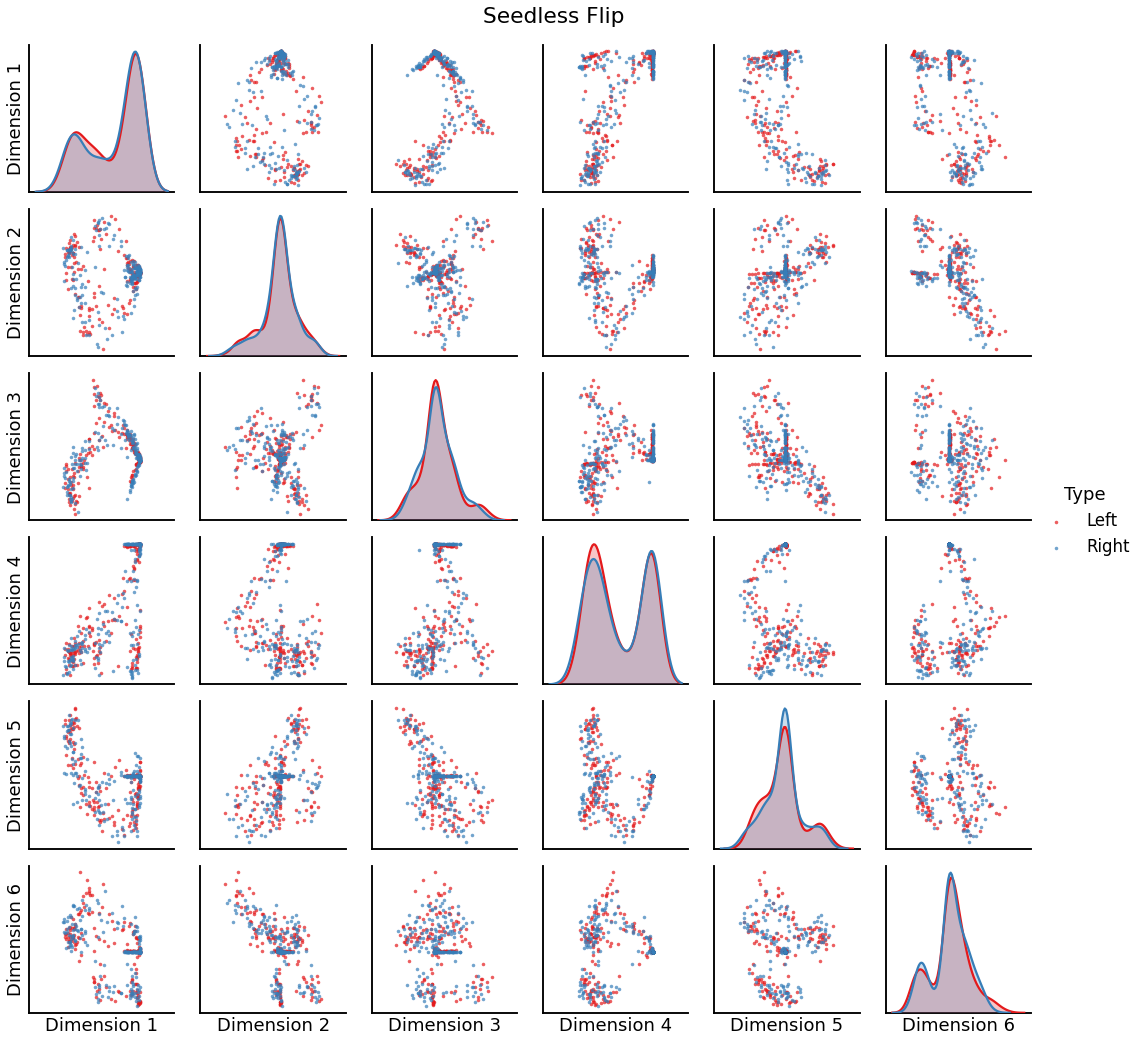

In [12]:
Q = SeedlessProcrustes().fit_predict(X1_hat, X2_hat)

X1_hat_seedless = X1_hat @ Q

fig = graspy.plot.pairplot(np.vstack([X1_hat_seedless, X2_hat]), labels=hemispheres, title="Seedless Flip")
#fig.savefig("flip_seedless.png", dpi=300, bbox_inches="tight")

In [13]:
tests = [KSample('Dcorr'), KSample('MGC'), KSample('HSic', compute_distance=gaussian)]
datas = [(X1_hat, X2_hat), (X1_hat_flipped, X2_hat_flipped), (X1_hat_seedless, X2_hat)]


pvals = []
for data in datas:
    for test in tests:
        res = test.test(*data)
        pvals.append(res[1])
        
pvals = np.array(pvals).reshape(3, -1).T

df = pd.DataFrame(
    pvals, 
    columns=['W/O Flip', 'Median Flip', 'Seedless Flip'],
    index=['Dcorr', 'MGC', 'HSIC']
)

In [14]:
df

,W/O Flip,Median Flip,Seedless Flip
Dcorr,0.471196,0.471196,1.000
MGC,0.001000,0.001000,0.965
HSIC,1.000000,1.000000,1.000
